# Named entity recognition model built in keras, trained on putput utterances and tokens

This notebook demonstrates using putput to generate data and train a named entity recognition model. Specifically, the notebook considers the scenario in which customers place orders at a restaurant. Labels follow the <a href="https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)">IOB2 format</a>.

For instance, given a customer's utterance:
* "can i have a chicken sandwich please"

the model should output the tokens
* "B-ADD_TO_ORDER I-ADD_TO_ORDER I-ADD_TO_ORDER B-QUANTITY B-ITEM I-ITEM O".

where "B-" indicates the beginning of a chunk, "I-" indicates inside a chunk, and "O-" indicates outside a chunk. In this scenario "can i have" is an ADD_TO_ORDER chunk, "a" is a QUANTITY chunk, and "please" is not part of any chunk.

This notebook borrows heavily from [an awesome blog series on deep learning for named entity recognition](https://www.depends-on-the-definition.com/guide-sequence-tagging-neural-networks-python/).

**If you would like to run this notebook yourself, you will need a GPU for training the LSTM.**

In [1]:
import itertools
from pathlib import Path
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from putput import ComboOptions
from putput import Pipeline
from seqeval.metrics import classification_report
from sklearn.model_selection import train_test_split

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Define all the functions we will need

In [2]:
def _bio_token_handler(token, phrase):
    tokens = ['{}-{}'.format('B' if i == 0 else 'I', token)
              for i, _ in enumerate(phrase.replace(" '", "'").split())]
    return ' '.join(tokens)

def _bio_group_handler(group_name, handled_tokens):
    num_tokens = 0
    for tokenized_phrase in handled_tokens:
        num_tokens += len(tokenized_phrase.split())
    groups = ['{}-{}'.format('B' if i == 0 else 'I', group_name)
              for i in range(num_tokens)]
    return ' '.join(groups)

In [3]:
def compute_utterances_and_tokens():
    pattern_def_path = Path(os.getcwd()) / "patterns.yml"
    dynamic_token_patterns_map = {
        "ITEM": ((("burger", "hamburger", "coke", "french fries", "chicken sandwich", "ten chicken strips"),),),
        "QUANTITY": ((("a", "the", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten"),),),
    }
    
    token_handler_map = {
        'DEFAULT': _bio_token_handler
    }

    group_handler_map = {
        'DEFAULT': _bio_group_handler
    }
    
    combo_options_map = {
        'DEFAULT': ComboOptions(max_sample_size=3000, with_replacement=True, seed=0)
    }

    all_utterances = []
    all_tokens = []
    p = Pipeline()
    for utterance, tokens, groups in p.flow(pattern_def_path,
                                            dynamic_token_patterns_map=dynamic_token_patterns_map,
                                            token_handler_map=token_handler_map,
                                            group_handler_map=group_handler_map,
                                            combo_options_map=combo_options_map):
        all_utterances.append(utterance)
        all_tokens.append(tokens)

    utterances = all_utterances
    utterances = [utterance.replace(" '", "'") for utterance in utterances]
    utterances = [utterance.split() for utterance in utterances]

    tokens = all_tokens
    tokens = [token.split() for token in tokens]
    return utterances, tokens

In [4]:
def compute_tags(tokens):
    tags = list(set(list(itertools.chain.from_iterable(tokens))))
    if 'O' not in tags:
        tags.append('O')
    return tags

In [5]:
def compute_word2idx(utterances):
    words = list(set(list(itertools.chain.from_iterable(utterances))))
    words.append("ENDPAD")
    words.append("UNKNOWN")
    word2idx = {w: i for i, w in enumerate(words)}
    return word2idx

In [6]:
def compute_tag2idx(tags):
    tag2idx = {t: i for i, t in enumerate(tags)}
    return tag2idx

In [7]:
def plot_histogram_length_of_utterances(utterances):
    plt.hist([len(utterance) for utterance in utterances], bins=50)
    plt.show()

In [8]:
def transform_utterances_for_keras(utterances, max_utterance_length, word2idx):
    X = [[(word2idx.get(word) or word2idx.get("UNKNOWN")) for word in phrase] for phrase in utterances]
    X = pad_sequences(maxlen=max_utterance_length, sequences=X, padding="post", value=word2idx['ENDPAD'])
    return X

In [9]:
def transform_tokens_for_keras(tokens, max_utterance_length, tag2idx):
    y = [[tag2idx[tag] for tag in token] for token in tokens]
    y = pad_sequences(maxlen=max_utterance_length, sequences=y, padding="post", value=tag2idx["O"])
    y = [to_categorical(i, num_classes=len(tag2idx)) for i in y]
    return y

In [10]:
def define_and_compile_model(max_utterance_length, num_unique_words, num_unique_tags):
    # bidirectional LSTM with custom word embeddings
    input = Input(shape=(max_utterance_length,))
    model = Embedding(input_dim=num_unique_words, output_dim=16, input_length=max_utterance_length)(input)
    model = Dropout(0.1)(model)
    model = Bidirectional(LSTM(units=16, return_sequences=True, recurrent_dropout=0.1))(model)
    out = TimeDistributed(Dense(num_unique_tags, activation="softmax"))(model)  # softmax output layer
    model = Model(input, out)
    model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [11]:
def train_model(X_tr, y_tr):
    history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=2, validation_split=0.1, verbose=1)
    return history

In [12]:
def plot_model_training(history):
    hist = pd.DataFrame(history.history)
    plt.figure(figsize=(12,12))
    plt.plot(hist["acc"])
    plt.plot(hist["val_acc"])
    plt.show()

In [13]:
def _convert_model_output_to_labels(pred, idx2tag):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out

In [14]:
def evaluate_model_on_test_split(model, X_te, y_te, tag2idx):
    idx2tag = {i: w for w, i in tag2idx.items()}
    test_pred = model.predict(X_te, verbose=1)
    pred_labels = _convert_model_output_to_labels(test_pred, idx2tag)
    test_labels = _convert_model_output_to_labels(y_te, idx2tag)
    return classification_report(test_labels, pred_labels)

In [15]:
def predict(model, pred_utterance, max_utterance_length, word2idx, tag2idx):
    pred_utterances = [pred_utterance.split()]
    X = transform_utterances_for_keras(pred_utterances, max_utterance_length, word2idx)    
    p = model.predict(np.array([X[0]]))
    p = np.argmax(p, axis=-1)

    idx2word = {idx: word for word, idx in word2idx.items()}
    idx2tag = {idx: word for word, idx in tag2idx.items()}
    
    formatted_prediction = "{:15}: {}".format("Word", "Pred")
    for w, pred in zip(X[0], p[0]):
        formatted_prediction += "\n{:15}: {}".format(idx2word[w], idx2tag[pred])
    return formatted_prediction

# Create utterances/tokens

In [16]:
utterances, tokens = compute_utterances_and_tokens()
tags = compute_tags(tokens)

# Analyze the utterances and tokens to determine max utterance length

There are 54000 utterances and they look like: ['i', 'will', 'have', 'to', 'order', 'five', 'burger', 'and', 'seven', 'french', 'fries']
There are 54000 tokens and they look like: ['B-ADD_TO_ORDER', 'I-ADD_TO_ORDER', 'I-ADD_TO_ORDER', 'I-ADD_TO_ORDER', 'I-ADD_TO_ORDER', 'B-QUANTITY', 'B-ITEM', 'B-CONJUNCTION', 'B-QUANTITY', 'B-ITEM', 'I-ITEM']


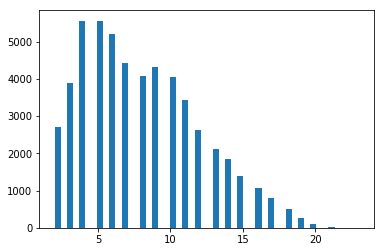

In [17]:
print("There are {} utterances and they look like:".format(len(utterances)), utterances[0])
print("There are {} tokens and they look like:".format(len(tokens)), tokens[0])
plot_histogram_length_of_utterances(utterances)
max_utterance_length = 30 # based on the histogram

Keras expects all utterances to be of the same length. Therefore we look at the distribution of lengths of utterances to determine what an appropriate maximum length should be. 

# Create a train test split of the data, in a format amenable to keras

In [18]:
word2idx = compute_word2idx(utterances)
tag2idx = compute_tag2idx(tags)
X = transform_utterances_for_keras(utterances, max_utterance_length, word2idx)
y = transform_tokens_for_keras(tokens, max_utterance_length, tag2idx)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

# Define and compile the model

In [19]:
model = define_and_compile_model(max_utterance_length, len(word2idx), len(tag2idx))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 30, 16)            1968      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 16)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 30, 32)            4224      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 11)            363       
Total params: 6,555
Trainable params: 6,555
Non-trainable params: 0
_________________________________________________________________


# Plot model training and analyze training

Train on 43740 samples, validate on 4860 samples
Epoch 1/2
43740/43740 [==============================] - 112s 3ms/step - loss: 0.2041 - acc: 0.9443 - val_loss: 0.0019 - val_acc: 0.9996
Epoch 2/2
43740/43740 [==============================] - 111s 3ms/step - loss: 0.0012 - acc: 0.9998 - val_loss: 6.5402e-04 - val_acc: 0.9998


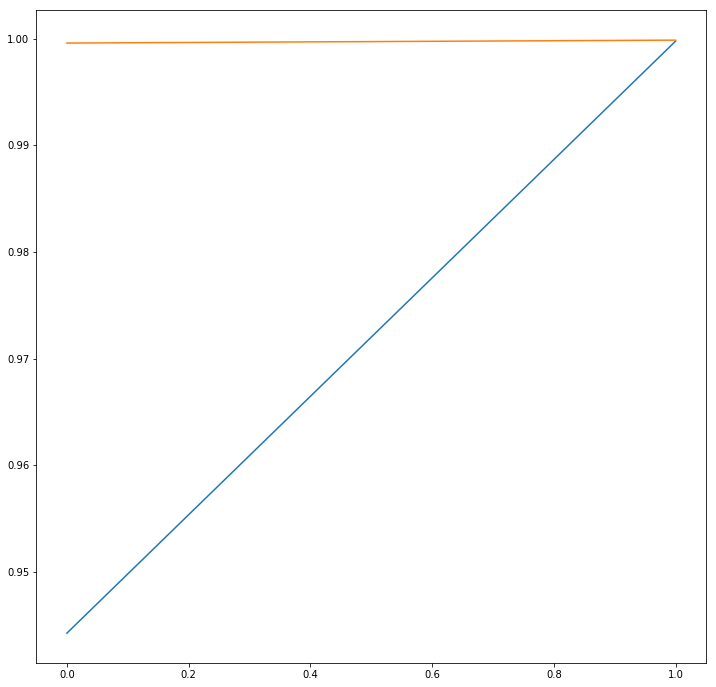

In [20]:
history = train_model(X_tr, y_tr)
plot_model_training(history)

Note: Here we can see that the model overfits the data from putput very quickly. This is both good and bad. It is good because it demonstrates that if you already have an existing model with this architecture, and you want to train it with utterances from putput, it is likely that the model has the capacity to learn the patterns well. It is bad because if you only have data from putput, the model will not generalize.

# Evaluate on test data

In [21]:
print(evaluate_model_on_test_split(model, X_te, y_te, tag2idx))

5400/5400 [==============================] - 6s 1ms/step
              precision    recall  f1-score   support

ADD_TO_ORDER       1.00      1.00      1.00      3513
END_OF_ORDER       0.98      0.97      0.98       302
        ITEM       1.00      1.00      1.00     10753
    QUANTITY       1.00      1.00      1.00      3887
 CONJUNCTION       1.00      1.00      1.00      1783
 REMOVE_ITEM       1.00      1.00      1.00      2975

 avg / total       1.00      1.00      1.00     23213



# Make predictions

In [22]:
print(predict(model, 'i want chicken sandwich', max_utterance_length, word2idx, tag2idx))

Word           : Pred
i              : B-ADD_TO_ORDER
want           : I-ADD_TO_ORDER
chicken        : B-ITEM
sandwich       : I-ITEM
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O


In [23]:
print(predict(model, 'i want chicken sandwich and remove burger', max_utterance_length, word2idx, tag2idx))

Word           : Pred
i              : B-ADD_TO_ORDER
want           : I-ADD_TO_ORDER
chicken        : B-ITEM
sandwich       : I-ITEM
and            : B-CONJUNCTION
remove         : B-REMOVE_ITEM
burger         : B-ITEM
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O


In [24]:
print(predict(model, 'i want a chicken sandwich and remove one burger and she need to order french fries', max_utterance_length, word2idx, tag2idx))

Word           : Pred
i              : B-ADD_TO_ORDER
want           : I-ADD_TO_ORDER
a              : B-QUANTITY
chicken        : B-ITEM
sandwich       : I-ITEM
and            : B-CONJUNCTION
remove         : B-REMOVE_ITEM
one            : B-QUANTITY
burger         : B-ITEM
and            : B-CONJUNCTION
she            : B-ADD_TO_ORDER
need           : I-ADD_TO_ORDER
to             : I-ADD_TO_ORDER
order          : I-ADD_TO_ORDER
french         : B-ITEM
fries          : I-ITEM
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O


In [25]:
print(predict(model, 'i want a chicken sandwich and ten ten chicken strips remove five french fries', max_utterance_length, word2idx, tag2idx))

Word           : Pred
i              : B-ADD_TO_ORDER
want           : I-ADD_TO_ORDER
a              : B-QUANTITY
chicken        : B-ITEM
sandwich       : I-ITEM
and            : B-CONJUNCTION
ten            : B-QUANTITY
ten            : B-ITEM
chicken        : I-ITEM
strips         : I-ITEM
remove         : B-REMOVE_ITEM
five           : B-QUANTITY
french         : B-ITEM
fries          : I-ITEM
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O


In [26]:
print(predict(model, 'remove a chicken', max_utterance_length, word2idx, tag2idx))

Word           : Pred
remove         : B-REMOVE_ITEM
a              : B-QUANTITY
chicken        : B-ITEM
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
